# Projet Prédiction du taux d'abstention aux élections municipales


## Plan

* [Présentation du projet](#chapter1)
    * [Introduction](#section_1_1)
    * [Motivations et Objectif](#section_1_2)
    * [Importation des données](#section_1_3)
    * [Premier aperçu des bases de données](#section_1_4)
    * [Prétraitement des données](#section_1_5)
* [Visualisation des données et analyse statistique](#chapter2)
    * [Distribution du taux d'abstention](#section_2_1)
    * [Influence des caractéristiques des communes sur le taux d'abstention](#section_2_2)
        * [Grandes villes et Abstention](#section_2_2_1)
        * [Age et Abstention](#section_2_2_2)
        * [Emploi et Abstention](#section_2_2_3)
        * [Niveau de vie et Abstention](#section_2_2_4)
* [Premier modèle de prédiction](#chapter3)
    * [Choix de la métrique et du cadre de test](#section_3_1)
    * [Perfomance minimale attendue du modèle ](#section_3_2)
    * [Evaluation du modèle](#section_3_3)
* [Explicabilité du modèle](#chapter4)




In [ ]:
import pandas as pd
import numpy as np
#import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost.sklearn import  XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import os
import json
import requests
import folium
import math as mt
from sklearn.model_selection import cross_val_score

# Présentation du projet <a class="anchor" id="chapter1"></a>

## Introduction <a class="anchor" id="section_1_1"></a>



Le vote est parfois considéré comme un droit, parfois comme un devoir. Dans certains pays d'Europe le fait de ne pas aller voter est sanctionnable d'une amende, rendant le vote un devoir, et obligeant de ce fait l'électeur a participer au fonctionnement du régime démocratique (même si c'est par l'intermédiaire d'un vote blanc). En France en revanche, le vote est un droit bien qu'il puisse être considéré comme un devoir moral. Cela laisse la possibilité à l'électeur de se désintéresser de l'offre politique en question. Une solution pourrait être de comptabiliser les votes blancs (qui ne le sont pas aujourd'hui) afin de pouvoir observer plus en détail le réel désintérêt que pourrait avoir la population à l'égard de l'offre politique. Cependant aujourd'hui un vote blanc ou un vote non exprimé sont considérés comme identiques.

Que ce soit pour des élections présidentielles, législatives ou municipales, on peut observer un fort taux d'abstention (plus ou moins fort selon l'élection en question). Nous nous sommes intéressés aux élections municipales dont le taux d'abstention lors des 4 dernières est affiché ci-dessous.

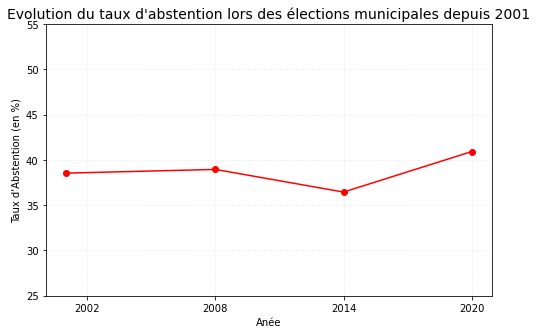

In [ ]:
evol = pd.read_csv('evolution.csv')

plt.figure(figsize=(8,5))
plt.plot(evol['Année'], evol['Taux d\'Abstention'], '-o', color='red')
plt.xlabel("Anée")
plt.ylabel("Taux d\'Abstention (en %)")
ticks = [2002, 2008, 2014, 2020]
labels = [2002, 2008, 2014, 2020]
plt.xticks(ticks, labels)
plt.title("Evolution du taux d'abstention lors des élections municipales depuis 2001", fontsize=14)
plt.ylim(25,55)
plt.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
plt.show()

## Motivations et Objectif  <a class="anchor" id="section_1_1"></a>

En 2020, les élections municipales ont connu des taux d'abstention record, notamment au second tour avec une moyenne de 58.4% sur le territoire français. Le taux d'abstention a dépassé dans certaines villes les 75% comme par exemple à Roubaix (77,25 %).

Ces records ont été enregistrés dans le contexte particulier de la pandémie, contexte qui peut expliquer un détournement d'une partie de la population des questions civiques. <br>

Cependant, nous avons eu l'intuition que ces conditions extrêmes, provoquant l'accentuation des inégalités sociales en France, ont pu également accentuer les variations du taux d'abstention à travers le pays, et révéler les facteurs principaux d'un fort taux d'abstention. <br>

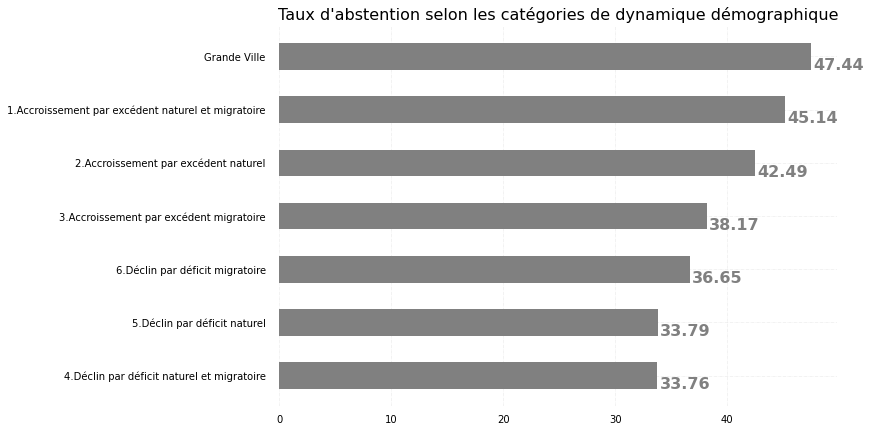

In [ ]:
dyna_demo = pd.read_csv('dyna_demo.csv')

fig, ax = plt.subplots(figsize =(10, 7)) 
  
# Horizontal Bar Plot 
ax.barh(dyna_demo['Dynamique Démographique BV'], dyna_demo['% Abs/Ins'], color='grey', height=0.5)

for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
ax.invert_yaxis() 

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 16, fontweight ='bold', 
             color ='grey') 
ax.set_title('Taux d\'abstention selon les catégories de dynamique démographique', 
             loc ='center', fontsize=16)
plt.show()

Ici par exemple, nous pouvons voir que les communes en déclin démographique présentent un plus faible taux d'abstention que celles qui voient leur population augmenter.

En effet, comme nous allons le voir par la suite, le taux d'abstention en France est très hétérogène et c'est une question sociale très complexe et primordiale que de comprendre quels sont les facteurs qui peuvent jouer sur ce taux. 
Nous avons rassemblé plusieurs bases de données contenant une gamme d'information socio-économique très large sur chaque ville afin de pouvoir considérer tous les facteurs possibles. <br>

Ce data challenge a donc pour objectif de **trouver les relations liant ces facteurs au taux d'abstention** par la construction d'un modèle prédictif adapté.

## Importation des données <a class="anchor" id="section_1_3"></a>

Nous avons utilisé 4 datasets, qui contiennent respectivement :
<br>
- Les résultats détaillés des éléctions municipales de 2020 pour les communes de plus de 1000 habitants
<br> https://www.data.gouv.fr/fr/datasets/elections-municipales-2020-resultats-1er-tour/
- Les résultats détaillés de ces éléctions pour les communes de moins de 1000 habitants https://www.data.gouv.fr/fr/datasets/elections-municipales-2020-resultats-1er-tour/
<br>
- Le niveau de vie dans chaque commune https://www.data.gouv.fr/fr/datasets/niveau-de-vie-des-francais-par-commune/
<br>
- Des données publiées par l'INSEE. Il y a une centaine de données par communes, que ce soit sur la présence de différents services et entreprises, le profil de la population ... https://www.data.gouv.fr/fr/datasets/data-insee-sur-les-communes/

A partir des ces données ont été crées nos données train et test.csv 

In [ ]:
path= 'data/'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_election = pd.read_csv(path + "train.csv")

## Premier aperçu des bases de données <a class="anchor" id="section_1_4"></a>
Voici un appercu du contenu du dataframes que nous avons : 


In [ ]:
display(df_election.head(5))

,Code de la commune,Code du département,Code Nuance,% Abs/Ins,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,...,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP,MED14
0,100,21,NC,14.71,21100,0.0,11.0,2.0,38,Bassin Résidentiel,...,7.58502,6.90138,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Faible Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,21,NaN
1,187,80,NC,26.47,80187,0.0,31.0,20.0,64,Bassin Urbain,...,8.27008,7.36530,Bassin Urbain en croissance démographique,Pop Sédentaire,Faible Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,80,22482.8
2,129,32,NC,28.45,32129,0.0,26.0,5.0,74,Bassin Résidentiel,...,11.82517,13.13235,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Faible Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,32,20036.0
3,671,80,NC,37.97,80671,0.0,15.0,5.0,65,Bassin Résidentiel,...,8.27008,7.36530,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Faible Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,80,15895.9
4,352,2B,NC,38.57,2B352,0.0,10.0,6.0,40,Bassin Résidentiel,...,0.00000,0.00000,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Faible Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,2B,18674.5


La base de données *df_election* contient entre autres les informations suivantes pour chaque commune française. Nous avons choisi de nous intéresser uniquement au taux d'abstention qui est nommé "%Abs/Ins", les autres variables indiquant des informations socio-économiques pour chaque communes  </li>. Nous possédons énormement des données sociaux économiques.

In [ ]:
for col in df_election.columns :
    if not 'Unnamed' in col :
        print(col)

Code de la commune
Code du département
Code Nuance
% Abs/Ins
CODGEO
Nb Pharmacies et parfumerie
Dynamique Entrepreneuriale
Dynamique Entrepreneuriale Service et Commerce
Synergie Médicale COMMUNE
Orientation Economique
Indice Fiscal Partiel
Score Fiscal
Indice Evasion Client
Score Evasion Client
Indice Synergie Médicale
Score Synergie Médicale
SEG Croissance POP
LIBGEO
REG
DEP
Nb Omnipraticiens BV
Nb Infirmiers Libéraux BV
Nb dentistes Libéraux BV
Nb pharmaciens Libéraux BV
Densité Médicale BV
Score équipement de santé BV
Indice Démographique
Score Démographique
Indice Ménages
Score Ménages
Population
Evolution Population
Evolution Pop %
Nb Ménages
Nb Résidences Principales
Nb propriétaire
Nb Logement
Nb Résidences Secondaires
Nb Log Vacants
Nb Occupants Résidence Principale
Nb Femme
Nb Homme
Nb Mineurs
Nb Majeurs
Nb Etudiants
Nb Entreprises Secteur Services
Nb Entreprises Secteur Commerce
Nb Entreprises Secteur Construction
Nb Entreprises Secteur Industrie
Nb Création Enteprises
Nb Cr

La base de données contient donc 101 variables détaillant diverses informations sur les 36 677 communes de France recensées, et sera donc une très bonne source d'informations pour tenter de comprendre les facteurs influençant le taux d'abstention si élevé lors des élections municipales. Nous allons regarder par la suite quelques uns de ces features, mais il serait trop long de regarder en détail chaque variable. Il est nécessaire d'en observer quelques unes  afin d'illustrer leurs influences.

Nous avons donc 3 bases de données à partir desquelles nous allons travailler, avec pour objectif final la prédiction du taux d'abstention dans le dataset *train*. 

Dans les parties qui suivent nous allons donc : 


*   Effectuer un **prétraitement** sur le dataset
*   **Analyser l'effet** de quelques variables sur le taux d'abstention
*   Construire un **modèle prédictif** 
*   Analyser la **performance** du modèle 


## Prétraitrement des données <a class="anchor" id="section_1_5"></a>

**Transformation de variables** 

Dans notre dataset, les variables contenat un nombre (comme nombre de commerces) sont transformée en nombre par habitant (nombre de commerces par habitant). Ceci nous permet d'avoir des données comparables entres grabdes et petites villes. 
<br>
<br>
Remarquons que certaines communes ne contiennent aucun habitant (comme par exemple certaines communes détruites lors de la bataille de Verdun). Pour crs communes, nous effecuons une division par zéro ce qui conduit à un résultat *+inf*. Nous remédions à ceci en remplaçant les valeurs *+inf* par zéro.

In [ ]:
col_nombre = ['Nb' in c for c in df_election.columns] # On récupère le nom des colonnes des informations comptées
total = df_election['Nb Femme'] + df_election['Nb Homme'] # On calcule le nombre d'habitants par communes
for c in df_election.columns[col_nombre]: # On effectue la division par le nombre d'habitants
  df_election[c] = df_election[c] / total

df_election = df_election.replace([np.inf, -np.inf], 0)
df_election.loc[:,col_nombre].head(5)

,Nb Pharmacies et parfumerie,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,...,Nb Logement Secondaire et Occasionnel,Nb Hotel,Nb Camping,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration"
0,0.0,0.108696,0.065217,0.021739,0.021739,0.239130,0.239130,0.239130,0.543478,0.239130,...,0.239130,0.0,0.0,0.000000,0.0,0.000000,56.000000,54.717391,18.978261,99.130435
1,0.0,0.008889,0.008889,0.004444,0.004444,0.185926,0.185926,0.157037,0.192593,0.002963,...,0.002963,0.0,0.0,0.000741,0.0,0.000741,2.420741,1.907407,0.574815,3.420741
2,0.0,0.077519,0.089147,0.038760,0.038760,0.197674,0.197674,0.155039,0.240310,0.038760,...,0.038760,0.0,0.0,0.000000,0.0,0.000000,7.500000,14.383721,4.736434,29.604651
3,0.0,0.073446,0.070621,0.019774,0.019774,0.183616,0.183616,0.161017,0.237288,0.036723,...,0.036723,0.0,0.0,0.000000,0.0,0.002825,9.231638,7.274011,2.192090,13.045198
4,0.0,0.059055,0.070866,0.023622,0.023622,0.248031,0.248031,0.177165,0.637795,0.374016,...,0.374016,0.0,0.0,0.003937,0.0,0.000000,0.118110,1.346457,0.736220,3.259843


Afin d'inclure ls données catégorielles dans notre modèle prédicitf, nous les transformons en One Hot Encoding. 
En effet, le but de notre modèle prédicitf est d'effectuer une régression, donc le One Hot Encoding convient très bien. 
(Si le but était d'effectuer une régression logistiquen le target encoding aurait semblé plus pertinent.) 

In [ ]:
#Les variables catégorielles sont les suivantes
Categorical_columns = [
                      'Orientation Economique',
                      'SEG Croissance POP',
                      'Urbanité Ruralité',
                      'Dynamique Démographique BV',
                      'Environnement Démographique',
                      'Fidélité',
                      'SYN MEDICAL',
                      'Seg Dyn Entre',
                      'SEG Environnement Démographique Obsolète',
                      'Seg Cap Fiscale',
                      'DYN SetC',
                      'CP' ]

In [ ]:
def class_features_transformation(data,col):
    '''One hot encoding pour des données catégorielles.

       Entrées
       -------
       data : dataframe
       col : string contenant le nom de la colonne

       Sortie
       ------
       data concat as many columns as classes in the feature 
    '''
    return pd.concat([data.drop(col, axis= 1 ) , pd.get_dummies(data[col])], axis=1)

In [ ]:
for col in Categorical_columns:
    df_election = class_features_transformation(df_election,col)

In [ ]:
print(df_election.shape)

(24294, 238)


# Visualisation des données et analyse statistique <a class="anchor" id="chapter2"></a>


## Distribution du taux d'abstention <a class="anchor" id="section_2_1"></a>

La donnée qui nous intéresse est le taux d'abstention par commune. Nous pouvons observer sa distribution qui est similaire à une gaussienne de moyenne 41% et d'écart-type 15%.

Text(0.5, 1.0, 'Distribution empirique de la variable taux abstention')

<Figure size 432x288 with 0 Axes>

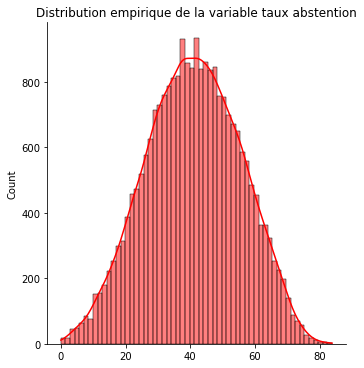

In [ ]:
plt.figure()
sns.displot(df_election['% Abs/Ins'].to_numpy(),kde =True,color ='red')
plt.title('Distribution empirique de la variable taux abstention')

In [ ]:
df_election['% Abs/Ins'].describe()

count    24294.000000
mean        40.930812
std         14.590323
min          0.000000
25%         30.610000
50%         41.050000
75%         51.500000
max         83.810000
Name: % Abs/Ins, dtype: float64

Le fait d'avoir une telle répartition des valeurs, à savoir des taux d'abstention allant de 0 à 83%, avec des quartiles éloignés de la moyenne, affirme la pertinance de la prédiction du taux d'abstention. 

Avec la carte suivante, on peut avoir une première impression de la distribution spatiale du taux d'abstention, et notamment de l'hétérogénéité de celui-ci à travers la France. Nous avons aggrégé le taux d'abstention par département pour rendre la visualisation plus légère. C'est donc une carte de chaleur où la variable est la moyenne du taux d'abstention par département. Plus on va vers les rouges, plus l'abstention est élevée en moyenne.

In [ ]:
election_by_dep = df_election[['% Abs/Ins','Code du département']].groupby(by = 'Code du département').mean()
election_by_dep = election_by_dep.reset_index()
election_by_dep.columns = ['code','% Abs/Ins']
election_by_dep['code'] = election_by_dep['code'].apply(str)

In [ ]:
with open(path+ 'donnees_geo/departements.geojson.txt') as json_file:
    data = json.load(json_file)

for f in data['features']:
  code = f['properties']['code']
  code = code.lstrip('0')
  f['code'] =code

data_geo = data

In [ ]:
m = folium.Map(location=[46,2],zoom_start=6,tiles="Mapbox Bright")
m.choropleth(
 geo_data=data_geo,
 name='choropleth',
 data=election_by_dep,
 columns=['code','% Abs/Ins'],
 key_on='feature.code',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Abstention en pourcentage'
)

folium.LayerControl().add_to(m)
m

On remarque que l'Ouest semble en moyenne plus affecté par l'abstentionnisme. L'Ile de France également est une zone sensible à ce phénomène.

## Influence des caractéristiques des communes sur le taux d'abstention <a class="anchor" id="section_2_2"></a>

Nous ne pouvons pas étudier la corrélation entre la sortie et toutes les variables, car le nombre de ces dernières est très grand. C'est pour cela que nous avons fait le choix de toutes les garder dans le modèle prédictif. Nous pouvons cependant illustrer le lien entre le taux d'abstention et certaines variables.

### Grandes villes et abstention <a class="anchor" id="section_2_2_1"></a>

On a représenté sur le graphe suivant le taux d'abstention en fonction du score d'urbanité. On peut également lire les distributions des deux variables. On voit bien que la majorité des communes en france sont des villes à très faible taux d'urbanisation, c'est à dire des petites villes de campagne. 
Parmi ces villes, le taux d'abstention semble parcourir toute la plage de taux d'abstention possible. 
Cependant, il est intéréssant de remarquer que le minimum du taux d'abstention augmente avec l'urbanisation. Autrement dit, plus on considère des grandes villes, plus il sera probable de ne jamais observer des scores d'abstention très faibles. On peut donc affirmer que les grandes villes ont des taux d'abstention plus élevés que les petites villes de campagne.

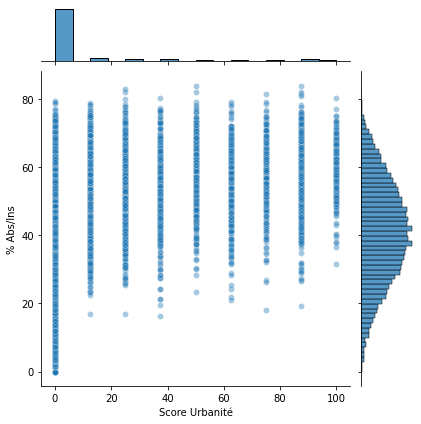

In [ ]:
sns.jointplot(data=df_election, x='Score Urbanité', y="% Abs/Ins",alpha=0.4)

In [ ]:
for col in df_election.columns:
    print(col)

Code de la commune
Code du département
Code Nuance
% Abs/Ins
CODGEO
Nb Pharmacies et parfumerie
Dynamique Entrepreneuriale
Dynamique Entrepreneuriale Service et Commerce
Synergie Médicale COMMUNE
Indice Fiscal Partiel
Score Fiscal
Indice Evasion Client
Score Evasion Client
Indice Synergie Médicale
Score Synergie Médicale
LIBGEO
REG
DEP
Nb Omnipraticiens BV
Nb Infirmiers Libéraux BV
Nb dentistes Libéraux BV
Nb pharmaciens Libéraux BV
Densité Médicale BV
Score équipement de santé BV
Indice Démographique
Score Démographique
Indice Ménages
Score Ménages
Population
Evolution Population
Evolution Pop %
Nb Ménages
Nb Résidences Principales
Nb propriétaire
Nb Logement
Nb Résidences Secondaires
Nb Log Vacants
Nb Occupants Résidence Principale
Nb Femme
Nb Homme
Nb Mineurs
Nb Majeurs
Nb Etudiants
Nb Entreprises Secteur Services
Nb Entreprises Secteur Commerce
Nb Entreprises Secteur Construction
Nb Entreprises Secteur Industrie
Nb Création Enteprises
Nb Création Industrielles
Nb Création Construct

Les remarques précédentes sont confirmées par les graphiques suivants. 

Text(0.5, 1.0, "Taux d'abstention en fonction de l'indice démographique par quantile")

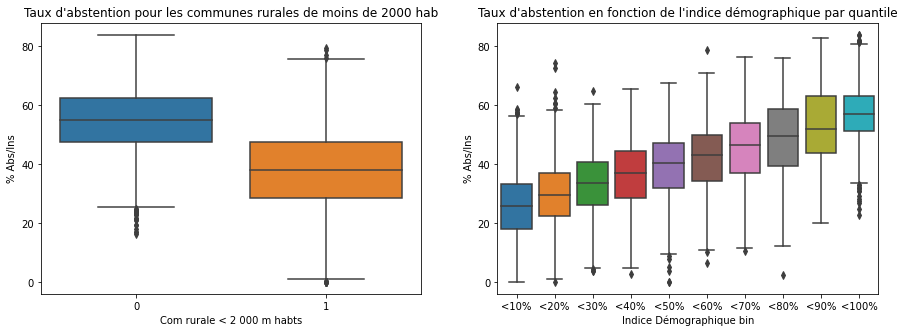

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15, 5))
sns.boxplot(x='Com rurale < 2 000 m habts', y='% Abs/Ins', data= df_election,ax=axs[0])
axs[0].set_title('Taux d\'abstention pour les communes rurales de moins de 2000 hab')

breaks = np.asarray(np.percentile(df_election['Indice Démographique'], [k*10 for k in range(1,11)])) # calcule des quantiles, pour pouvoir séparer les données en 10.
df_election['Indice Démographique bin'] = (df_election['Indice Démographique'].values > breaks[..., np.newaxis]).sum(0)  # On créée une nouvelle variable 'Indice demographique binnée
df_election['Indice Démographique bin'] = df_election['Indice Démographique bin'].apply(lambda x: '<' + str(x*10+10)+ '%') # Les variables d'origines sont 0, 1, 2, ... 9 cela devient '<10%','<20%',.....
sns.boxplot(x='Indice Démographique bin', y='% Abs/Ins', data= df_election.sort_values(by='Indice Démographique'),ax=axs[1])
axs[1].set_title('Taux d\'abstention en fonction de l\'indice démographique par quantile')


Nous pouvons donc confirmer avec le graphique à gauche, que le taux d'abstention est bien plus faible pour des petites villes de campagne. A droite, on a bien l'augmentation du taux d'abstention en fonction du nombre d'habitant, et donc de la taille de la ville.

### Age et abstention <a class="anchor" id="section_2_2_2"></a>

* Nous pouvons emettre l'hypothèse que l'âge des votants a un impact fort sur l'abstention. 
En effet, la moyenne d'âges dans les petits villages peut être plus élevée que celle dans les grandes villes urbaines. Cette hypothèse est soutenue par les deux graphes ci-dessous :


Text(0.5, 1.0, "Taux d'abstention en fonction du nombre d'étudiant par quantile et du type de commune.")

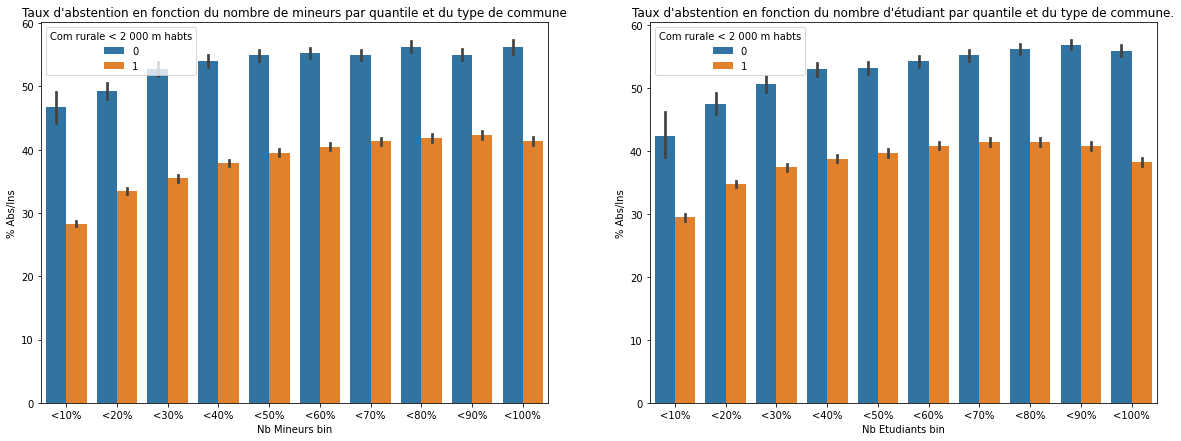

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20, 7))

breaks = np.asarray(np.nanpercentile(df_election['Nb Mineurs'], [k*10 for k in range(1,11)])) # calcule des quantiles, pour pouvoir séparer les données en 10.
df_election['Nb Mineurs bin'] = (df_election['Nb Mineurs'].values > breaks[..., np.newaxis]).sum(0)  # On créée une nouvelle variable 'Indice demographique binnée
df_election['Nb Mineurs bin'] = df_election['Nb Mineurs bin'].apply(lambda x: '<' + str(x*10+10)+ '%') # Les variables d'origines sont 0, 1, 2, ... 9 cela devient '<10%','<20%',.....

breaks = np.asarray(np.nanpercentile(df_election['Nb Etudiants'], [k*10 for k in range(1,11)])) # calcule des quantiles, pour pouvoir séparer les données en 10.
df_election['Nb Etudiants bin'] = (df_election['Nb Etudiants'].values > breaks[..., np.newaxis]).sum(0)  # On créée une nouvelle variable 'Indice demographique binnée
df_election['Nb Etudiants bin'] = df_election['Nb Etudiants bin'].apply(lambda x: '<' + str(x*10+10)+ '%') # Les variables d'origines sont 0, 1, 2, ... 9 cela devient '<10%','<20%',.....


sns.barplot(x="Nb Mineurs bin", y="% Abs/Ins", data=df_election.sort_values(by=['Nb Mineurs']), estimator=np.mean, hue="Com rurale < 2 000 m habts", ax=axs[0])
axs[0].set_title('Taux d\'abstention en fonction du nombre de mineurs par quantile et du type de commune')

title = 'Taux d\'abstention en fonction du Nb Atifs et du type de commune'
sns.barplot(x="Nb Etudiants bin", y="% Abs/Ins", data=df_election.sort_values(by=['Nb Etudiants']), estimator=np.mean, hue="Com rurale < 2 000 m habts",ax=axs[1])
axs[1].set_title("Taux d\'abstention en fonction du nombre d'étudiant par quantile et du type de commune.") 

### Emploi et abstention <a class="anchor" id="section_2_2_3"></a>

Sachant que le facteur emploi en dit beaucoup sur la situation socio-économique d'une ville, on peut se douter que cette variable aura un impact sur le taux d'abstention, dont on se propose de regarder plus en détail les effets ici.

Text(0.5, 1.0, "Taux d'abstention et Proportion de salariés ")

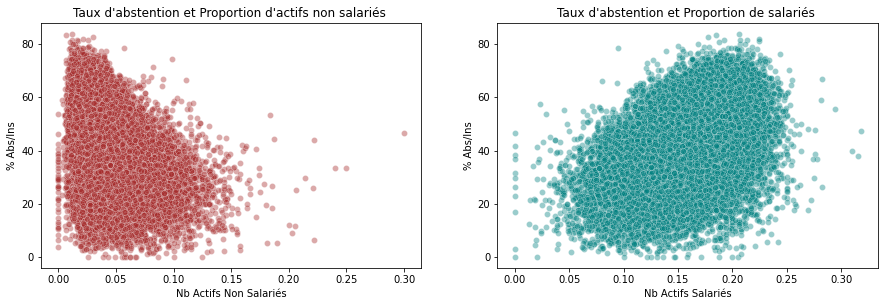

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15, 4.5))
sns.scatterplot(data=df_election, x='Nb Actifs Non Salariés', y="% Abs/Ins",ax=axs[0],alpha=0.4,color='brown')
sns.scatterplot(data=df_election, x='Nb Actifs Salariés', y="% Abs/Ins",ax=axs[1],alpha=0.4,color='teal')

axs[0].set_title('Taux d\'abstention et Proportion d\'actifs non salariés ')
axs[1].set_title('Taux d\'abstention et Proportion de salariés ')

Il y a une nette décroissance du taux d'abstention maximal avec le nombre d'actifs non salariés. Anisi, plus la proportion d'actifs non salariés est élevée, plus le taux d'abstention sera plafonné et restera faible. Cette catégorie de professionnels qui comprend les libéraux (avocats, médecins..) correspond en général à une classe sociale élevée. On pourra voir dans la partie suivante un phénomène allant dans le même sens.
Concernant le nombre d'actifs salariés c'est l'effet inverse qu'on observe, on peut voir un nuage de points avec une légère tendance croissante.


### Niveau de vie et Abstention <a class="anchor" id="section_2_2_4"></a>

Text(0.5, 1.0, "Taux d'abstention en fonction de la proportion de propriétaire par quantile")

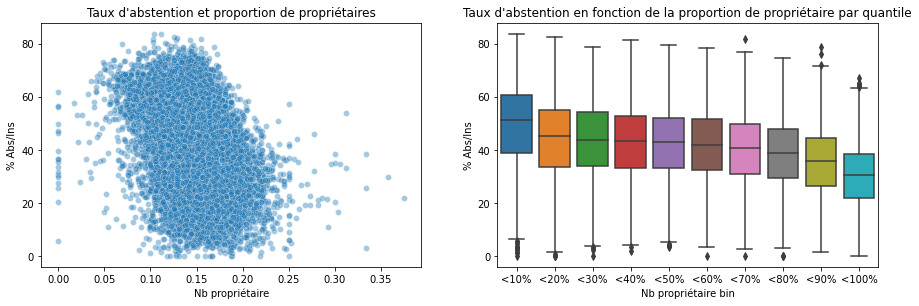

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15, 4.5))
sns.scatterplot(data=df_election, x='Nb propriétaire', y="% Abs/Ins",alpha = 0.4,ax=axs[0])
axs[0].set_title("Taux d'abstention et proportion de propriétaires")

breaks = np.asarray(np.percentile(df_election['Nb propriétaire'], [k*10 for k in range(1,11)])) # calcule des quantiles, pour pouvoir séparer les données en 10.
df_election['Nb propriétaire bin'] = (df_election['Nb propriétaire'].values > breaks[..., np.newaxis]).sum(0)  # On créée une nouvelle variable 'Indice demographique binnée
df_election['Nb propriétaire bin'] = df_election['Nb propriétaire bin'].apply(lambda x: '<' + str(x*10+10)+ '%') # Les variables d'origines sont 0, 1, 2, ... 9 cela devient '<10%','<20%',.....
sns.boxplot(x='Nb propriétaire bin', y='% Abs/Ins', data= df_election.sort_values(by='Nb propriétaire'),ax=axs[1])
axs[1].set_title('Taux d\'abstention en fonction de la proportion de propriétaire par quantile')

Les informations données par les variables visualisées sur le taux d'abstention dans cette partie sont très grossières.
Cependant, on voit qu'il est possible d'entrevoir des liens logiques et des dépendances entre les variables. Cette première visualisation des données nous conforte dans le fait que l'ensemble des variables présentes dans le data set nous seront utiles pour prédire la sortie.
Nous avons en effet choisi de garder l'ensemble des features car ils sont très riches en information et qu'en retirer impliquerait de prendre le risque de retirer une information précieuse à partir d'un mauvais jugement. 

# Premier modèle de prédiction <a class="anchor" id="chapter3"></a>

Ici l'objectif est de mettre en place un premier modèle simple, et d'évaluer sa performance afin d'amorcer le data challenge qui consistera à améliorer le modèle proposé.
L'objectif est aussi de justifier la démarche globale du projet en montrant qu'il est pertinent d'utiliser un modèle de machine learning sur ces données.

On choisit d'utiliser un modèle de régression XGBoost. La régression implique que l'on doit retirer des variables de notre dataset avant de continuer: en effet un tel modèle suppose que les variables explicatives sont indépendantes entre elles. Or on ne peut pas supposer une telle chose lorsqu'on travaille avec des variables fortement correlées. On se propose donc de faire une analyse rapide de la matrice des correlations afin de retirer les variables fortement correlées à d'autres. Cela permettra a priori a notre modèle d'être plus performant car il accordera plus d'importance aux variables statisquement plus significatives.

In [ ]:
# On calcule la matrice de correlations en retirant les variables relatives à l'identification et la variable cible

corr_mat = df_election.drop(['Code de la commune', '% Abs/Ins', 'CODGEO','LIBGEO','REG','DEP','Code Nuance','Code du département','% Abs/Ins','Indice Démographique bin','Nb Mineurs bin','Nb Etudiants bin','Nb propriétaire bin'], axis = 1).corr()
corr_mat.head(10)

,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,...,86,87,88,89,90,91,92,93,94,95
Nb Pharmacies et parfumerie,1.000000,0.017168,0.014421,0.095271,0.000520,0.000520,0.010593,0.010593,0.095271,0.095271,...,-0.005127,-0.005953,-0.009853,-0.000851,-0.004261,0.003364,0.010432,0.001399,0.003247,-0.000717
Dynamique Entrepreneuriale,0.017168,1.000000,0.987423,0.922318,-0.038014,-0.038014,0.632552,0.632552,0.922318,0.922318,...,-0.003397,0.000901,-0.016336,-0.017772,-0.008773,0.059373,0.190104,0.167585,0.149203,0.044846
Dynamique Entrepreneuriale Service et Commerce,0.014421,0.987423,1.000000,0.895813,-0.021144,-0.021144,0.639708,0.639708,0.895813,0.895813,...,0.000129,0.004382,-0.012392,-0.013094,-0.006216,0.028331,0.183486,0.118388,0.119753,0.016334
Synergie Médicale COMMUNE,0.095271,0.922318,0.895813,1.000000,-0.092075,-0.092075,0.558559,0.558559,1.000000,1.000000,...,-0.020637,-0.018157,-0.026800,-0.028150,-0.016547,0.129041,0.253231,0.171769,0.165284,0.114760
Indice Fiscal Partiel,0.000520,-0.038014,-0.021144,-0.092075,1.000000,1.000000,0.004247,0.004247,-0.092075,-0.092075,...,-0.131590,-0.006902,-0.279893,0.059892,0.027392,-0.099295,-0.039071,-0.048241,-0.053264,-0.094368
Score Fiscal,0.000520,-0.038014,-0.021144,-0.092075,1.000000,1.000000,0.004247,0.004247,-0.092075,-0.092075,...,-0.131590,-0.006902,-0.279893,0.059892,0.027392,-0.099295,-0.039071,-0.048241,-0.053264,-0.094368
Indice Evasion Client,0.010593,0.632552,0.639708,0.558559,0.004247,0.004247,1.000000,1.000000,0.558559,0.558559,...,-0.000794,0.000432,-0.011401,-0.014264,-0.008885,0.004516,0.073965,0.053534,0.046954,-0.004115
Score Evasion Client,0.010593,0.632552,0.639708,0.558559,0.004247,0.004247,1.000000,1.000000,0.558559,0.558559,...,-0.000794,0.000432,-0.011401,-0.014264,-0.008885,0.004516,0.073965,0.053534,0.046954,-0.004115
Indice Synergie Médicale,0.095271,0.922318,0.895813,1.000000,-0.092075,-0.092075,0.558559,0.558559,1.000000,1.000000,...,-0.020637,-0.018157,-0.026800,-0.028150,-0.016547,0.129041,0.253231,0.171769,0.165284,0.114760
Score Synergie Médicale,0.095271,0.922318,0.895813,1.000000,-0.092075,-0.092075,0.558559,0.558559,1.000000,1.000000,...,-0.020637,-0.018157,-0.026800,-0.028150,-0.016546,0.129041,0.253231,0.171769,0.165284,0.114760


Après rapide coup d'oeil, on se rend bien compte que certaines variables sont quasiment dupliquées, comme par exemple **Dynamique Entrepreneuriale Service et Commerce et Dynamique Entrepreneuriale**. Il s'agit alors d'en garder qu'une seule des 2 dans cet exemple précis. Nous allons donc parcourir notre matrice de corrélations afin d'identifier les couples de variables qui sont correlés au delà d'un certain seuil et en retirer une des deux de notre dataframe avant de tenter une prédiction.

In [ ]:
def corr_couples(df, corr_coef=0.5):
  """Retourne des couples de variables avec une correlation supérieure à corr_coef.

  Entrée
  ------
  matrice de correlations

  Sortie
  ------
  liste de liste de triplets [variable, variable, correlation]
  """
  l = []
  for i in range(len(df.columns)) :
    for j in range(i+1, len(df.columns)) :
        if df.iloc[i][j] >= corr_coef:
          l.append([df.columns[i], df.columns[j], df.iloc[i][j]])
  return l

couples = corr_couples(corr_mat)
print('On a un total de ', len(couples), ' couples de variables correlées.') 

On a un total de  326  couples de variables correlées.


Il s'agit maintenant de retirer ces variables.

In [ ]:
def remove_corr(df, l):
  """Retire des colonnes de la dataframe en fonction de la liste de correlations l

  Entrée
  ------
  dataframe df
  liste l définie par la fonction corr_couples

  Sortie
  ------
  dataframe réduit
  liste de noms de variables retirées
  """
  # On créé la liste de noms uniques de variables correlées entre elles
  names = []
  
  for i in range (len(l)):
    if l[i][0] and l[i][1] in df.columns:  # Si les deux variables sont encore présentes dans le dataframe
      df.drop(l[i][1], axis=1, inplace=True)  # On supprime la deuxième variable (mais ça pourrait être la première)
      names.append(l[i][1])
  
  return df, names
  
  df_election, names_to_drop = remove_corr(df_election, couples)

On sépare  la target des features, et on retire les identifiants des villes.


In [ ]:
X = df_election.drop(['CODGEO','LIBGEO','REG','DEP','Code Nuance','Code du département','% Abs/Ins','Indice Démographique bin','Nb Mineurs bin','Nb Etudiants bin','Nb propriétaire bin'],axis=1)
y = df_election[['% Abs/Ins']]

## Choix de la métrique et du cadre de test <a class="anchor" id="section_3_1"></a>


On va quantifier l'erreur de prédiction commise par notre modèle avec la métrique Mean Squared Error (MSE). Nous faisons ce choix car c'est une métrique fiable pour des problèmes de régression, qui pénalise notamment les grandes erreurs. On rappelle la formule ci dessous:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{pred,i}-y_{true,i})^2$$

La différence entre réalité et prédiction étant mise au carré, cette valeur n'a plus la dimension d'un taux d'abstention. Pour revenir à une erreur de taux d'abstention, il sera utile de regarder la métrique Root Mean Squared Error (RMSE) qui n'est autre que :
$$ RMSE = \sqrt {MSE }$$

De plus, afin d'avoir une estimation du risque de notre modèle plus fine, on procède à une cross-validation avec k=8 folds. En prenant la moyenne de l'erreur obtenue sur les 8 ensembles de test, on réduit la variance de l'erreur d'estimation du risque considérablement. Si on note $RMSE_j$ l'erreur obtenue sur le j-ème fold, le risque du modèle s'exprime comme suit :
$$\hat{R}(model) = mean((RMSE_j)_{j=1}^k) \pm std((RMSE_j)_{j=1}^k)$$


## Perfomance minimale attendue du modèle <a class="anchor" id="section_3_2"></a>


Il est important avant de juger la performance de notre modèle de connaître la performance minimale à obtenir. 
En effet en prenant l'espérance de l'abstention sur les données d'entraînement, et renvoyant cette dernière en temps que prédiction, on obtient une différence relative de 15 %.
Ainsi, si notre modèle possède une erreur relative plus grande ou proche de 15 %, on peut remettre en cause la création de notre modèle et son utilité. 

En effet, cela signifierait que connaître l'abstention dans quelques communes serait plus précis que de faire un modèle sur le taux d'abstention.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

dumb_regressor = DummyRegressor(strategy = 'mean')
scores = cross_val_score(dumb_regressor , X, y, cv=8,scoring ='neg_mean_squared_error')
scores = [-1*score for score in scores]

mean = mt.sqrt(np.mean(scores))
std =  mt.sqrt(np.std(scores)) 

print("Erreur de prédiction du modèle dummy du taux d'abstention par la moyenne de l'ensemble d'entrainement:  %.2f  +/- %.2f " %(mean,std))

Erreur de prédiction du modèle dummy du taux d'abstention par la moyenne de l'ensemble d'entrainement:  14.59  +/- 2.07 


## Evaluation du modèle <a class="anchor" id="section_3_3"></a>

On a décidé d'utiliser la bibliothèque XGBoost pour notre création de modèle. XGBoost fonctionnant avec des techniques d'arbres de décision, nous n'avons pas besoin de mettre à l'échelle nos variables avec MinMaxScaler par exemple.
On fait le choix de remplacer les valeurs manquantes par les valeurs les plus fréquentes. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ShuffleSplit

pipeline = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                           ('xgb', XGBRegressor(random_state=42))])

cv = ShuffleSplit(n_splits=8, test_size=0.25)
scores = cross_val_score(pipeline,X,y,cv=cv,scoring ='neg_mean_squared_error')
scores = [-1*score for score in scores]
                          
mean = mt.sqrt(np.mean(scores))
std =  mt.sqrt(np.std(scores))

print("Erreur de prédiction de notre modèle du taux d'abstention par la moyenne de l'ensemble d'entrainement:  %.2f  +/- %.2f " %(mean,std))

Erreur de prédiction de notre modèle du taux d'abstention par la moyenne de l'ensemble d'entrainement:  10.27  +/- 1.48 


Dans notre cas, on obtient une erreur moyenne de 10%. On peut considérer que la création d'un modèle, ici, fait sens. En effet notre modèle approxime de manière plus précise le taux d'abstention que la valeur moyenne d'apprentissage. On remarque que notre modèle est beaucoup plus fiable car la variance de l'erreur a considérablement réduit. C'est donc la confirmation de ce qu'on a vu en première partie avec la visualisation des données : il y a des dépendances entre les différentes variables et le taux d'abstention.

On peut s'intéresser à la visualisation de l'erreur de prediction pour un ensemble de test.

Text(0.5, 1.0, "Comparaison graphique du taux d'abstention prédit et réel")

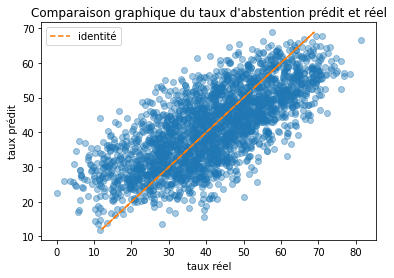

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42,test_size = 0.1)

model =  XGBRegressor(random_state=42)
imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

fig,ax=plt.subplots()
ax.plot( y_test.to_numpy(),y_pred,'o',alpha=0.4)
ax.plot(y_pred,y_pred,'--',label='identité')
ax.set_xlabel('taux réel')
ax.set_ylabel('taux prédit')
ax.legend()
ax.set_title("Comparaison graphique du taux d'abstention prédit et réel")

Notre modèle à l'air de mieux prédire les valeurs pour les communes qui ont un taux d'abstention proche de la moyenne. Il a cependant plus de mal à prédire notemment les très faibles taux d'abstention. Il y a une forte erreur de prédiction pour ces communes là. 

## Workflow <a class="anchor" id="section_3_4"></a>

Nous créons ci dessous une Pipeline qui sera entrainé à l'aide d'une cross-validation sur les données d'entraînements et ensuite testée sur les données de test. 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost.sklearn import  XGBRegressor

def class_features_transformation(data, col):
    return pd.concat([data.drop(col, axis=1), pd.get_dummies(data[col])], axis=1)


def CODGEO_to_departement(string):
    """Retourne le numéro du département du code postal donné en entrée.

Entrée
------
string : chaîne de caractère donnant le code postal de la commune

Sortie
------
numéro du département (int, à part pour la corse)
"""
    if '2A' in string:
        return '2A'
    if '2B' in string:
        return '2B'
    else:
        return int(string[:2].lstrip('0'))  #on prend les deux premiers chiffres du code postal


def to_num(x):
    """Retourne le numéro du département en entier si c'en est un.

Entrée
------
string : chaîne de caractère donnant le code postal de la commune

Sortie
------
numéro du département (int, à part pour la corse ou autre Z..)
"""
    if type(x) == str:
        for char in x:
            if char not in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
                return(x)
            else:
                return int(x)
        else:
            return x

def _preprocessor(X):

    df_election = X

    col_nombre = ['Nb' in c for c in df_election.columns] 
    total = df_election['Nb Femme'] + df_election['Nb Homme'] 
    for c in df_election.columns[col_nombre]:
        df_election[c] = df_election[c] / total
    df_election = df_election.replace([np.inf, -np.inf], 0)
    Categorical_columns = [
                      'Orientation Economique',
                      'SEG Croissance POP',
                      'Urbanité Ruralité',
                      'Dynamique Démographique BV',
                      'Environnement Démographique',
                      'Fidélité',
                      'SYN MEDICAL',
                      'Seg Dyn Entre',
                      'SEG Environnement Démographique Obsolète',
                      'Seg Cap Fiscale',
                      'DYN SetC',
                      'CP' ]
    for col in Categorical_columns:
        df_election = class_features_transformation(df_election,col)
    
    return df_election


def get_estimator():

    drop_cols = ['CODGEO', 'LIBGEO', 'REG', 'DEP', 'Code Nuance',
                 'Code du département']
    base_cols = [
        'Orientation Economique', 'SEG Croissance POP', 'Urbanité Ruralité',
        'Dynamique Démographique BV', 'Environnement Démographique',
        'Fidélité', 'SYN MEDICAL', 'Seg Dyn Entre',
        'SEG Environnement Démographique Obsolète', 'Seg Cap Fiscale',
        'DYN SetC', 'CP', 'MED14', 'Nb Femme', 'Nb Homme'
        ]
    
    base_transformer = FunctionTransformer(
        _preprocessor, validate=False
    )

    base_transformer = make_pipeline(
        base_transformer, SimpleImputer(strategy='most_frequent')
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('base', base_transformer, base_cols),
            ('drop cols', 'drop', drop_cols),
        ], remainder='passthrough')  # remainder='drop' or 'passthrough'

    regressor = XGBRegressor()

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('Regressor', regressor)
    ])

    return pipeline

In [ ]:
df_election = pd.read_csv(path + "train.csv")
# On importe les données d'entrainement
X_train = df_election.drop("% Abs/Ins", axis=1)
Y_train = df_election["% Abs/Ins"]
pipe = get_estimator()

*Nous effectuons ensuite une crossvalidation du modèle :*

In [ ]:
cv = cross_val_score(pipe, X_train, Y_train, cv=3, scoring='neg_mean_squared_error' )
scores = np.sqrt(-cv)
mean = (np.mean(scores))
std =  (np.std(scores)) 
print("Erreur de prédiction du taux d'abstention par la moyenne de l'ensemble d'entrainement:  %.2f  +/- %.2f " %(mean,std))

# Explicabilité du modèle <a class="anchor" id="chapter4"></a>

In [ ]:
pd.set_option('display.max_rows', 20) # On remet en petit

importance = pd.DataFrame({'feature' : X.columns ,'importance' : model.feature_importances_})
importance.sort_values(by='importance',ascending =False)

Nous remarquons (comme nous l'avions évoqué dans les analyses), que l'indice démographique joue un rôele essentiel dans notre prédiction. 
S'ensuit l'importance du caractère urbain/rural de la commune et le nombre d'actifs salariés. 